In [1]:
# Basic utils
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CV & scoring utils
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from itertools import product, chain, combinations
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Regression utils
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch
import tensorflow as tf
from surprise.reader import Reader
from xgboost import XGBRegressor as XGB
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RF

# Preprocessing utils
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, StandardScaler

# Display utils
import warnings
from sklearn import set_config
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

warnings.simplefilter("ignore")
set_config(transform_output="pandas")
plt.rcParams.update({'font.size': 20})
pd.set_option('display.width', 5000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 20)
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:90% !important; }</style>"))


2024-04-16 11:06:37.609370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 11:06:37.645895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 11:06:38.469457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


___________

# Data preprocessing

## Load performance data, add LLM/GPU features, encode

In [2]:
results = pd.read_csv("../preprocess_data/performance_characterization_data.csv", index_col=0)
gpu_features = pd.read_csv("gpu_features.csv", index_col=0)
model_features = pd.read_csv("llm_features.csv")

df_raw = pd.DataFrame()

for idx, row in results.iterrows():
    model_info = model_features[model_features['model'] == row['model']].iloc(0)[0].to_dict()
    gpu_info = gpu_features[gpu_features['gpu'] == row['gpu']].iloc(0)[0].to_dict()
    gpu_info['gpu_n_gpus'] = int(row['gpu'][0])
            
    new_entry = {**row.to_dict(), 
                 **model_info, 
                 **gpu_info}
    new_series = pd.Series(new_entry)
    df_raw = pd.concat([df_raw, new_series.to_frame().T], ignore_index=True)

df_enc_oh = df_raw.copy()
df_enc_lab = df_raw.copy()

for col in df_raw.columns:
    
    # Skip non-feature columns
    if 'model_' not in col and 'gpu_' not in col:
        continue
        
    col_dtype = type(df_raw[col].unique()[0])
    if col_dtype is str:
        df_enc_oh = pd.get_dummies(df_enc_oh, columns=[col])
        df_enc_lab[col] = df_enc_lab[col].astype('category').cat.codes
    elif col_dtype is np.bool_:
        df_enc_oh[col] = df_enc_oh[col].apply(int)
        df_enc_lab[col] = df_enc_lab[col].apply(int)

df_enc_oh = df_enc_oh.fillna(-1)
df_enc_oh.to_csv("historical_performance_data_one_hot.csv")

df_enc_lab = df_enc_lab.fillna(-1)
df_enc_lab.to_csv("historical_performance_data_label.csv")

## Add sample weights

In [3]:
TARGET_SLAS = (100, 50)

def get_sample_weights(latencies, sla):
    minimum = np.min(latencies)
    maximum = np.max(latencies)
    dist = max(np.abs(sla-minimum), np.abs(maximum - sla))
    
    weights = [1 - (np.abs(l - sla)/dist) for l in latencies]
    sum_w = np.sum(weights)
    assert(sum_w > 0)
    weights_norm = [w/sum_w for w in weights]
    return weights_norm
    
df = pd.read_csv("historical_performance_data_label.csv", index_col=0)

nttft_weights = []
itl_weights = []
for m in df['model'].unique():
    dfm = df[df['model'] == m]
    for g in dfm['gpu'].unique():
        dfg = dfm[dfm['gpu'] == g]
        nttft_weights.extend(get_sample_weights(dfg['median_nttft'], TARGET_SLAS[0]))
        itl_weights.extend(get_sample_weights(dfg['median_itl'], TARGET_SLAS[1]))
        
df['util_sample_weights_nttft'] = nttft_weights
df['util_sample_weights_itl'] = itl_weights
df['util_sample_weights_mean'] = [(w1 + w2)/2 for w1, w2 in zip(df['util_sample_weights_nttft'], df['util_sample_weights_itl'])]

df.to_csv("historical_performance_data_label.csv")


## Add reference performance evaluations

In [4]:
df = pd.read_csv("historical_performance_data_label.csv", index_col=0)

REFERENCE_PERFORMANCE_METRICS = ['median_nttft', 'median_itl', 'throughput']
REFERENCE_U_MAX_METRICS = ['nttft', 'itl', 'joint']
REFERENCE_GPU_PROFILES = ['1 x T4', '4 x H100']
TARGET_SLAS = (100, 50)

    
def interpolate_num_users_at_sla(latencies, num_users, sla):
    out_u = 0
    if sla < np.min(latencies):
        out_u = 0
    elif sla > np.max(latencies):
        out_u = np.max(num_users)
    else:
        for l1, l2, u1, u2 in zip(latencies[:-1], latencies[1:], num_users[:-1], num_users[1:]):
            if (l1 <= sla and l2 >= sla):
                if l1 == l2:
                    out_u = max(u1, u2)
                else:
                    out_u = u1 + (u2 - u1)*(sla - l1)/(l2 - l1)
                break
    return np.floor(out_u)

features = []
for fingerprint_GPU in REFERENCE_GPU_PROFILES:
    gpu_short = fingerprint_GPU.replace(' ', '').lower()
    features.extend(['fingerprint_' + gpu_short + '_users_max_' + suffix for suffix in REFERENCE_U_MAX_METRICS])
    for metric in REFERENCE_PERFORMANCE_METRICS:
        for num_users in df['num_users'].unique():
            features.append('fingerprint_' + gpu_short + '_' + metric + '_' + str(num_users))
fingerprint_features = {f: [] for f in features}

# Extract fingerprint
for fingerprint_GPU in REFERENCE_GPU_PROFILES:
    gpu_short = fingerprint_GPU.replace(' ', '').lower()
    for m in df['model'].unique():
        dfm = df[df['model'] == m]
        dff = dfm[dfm['gpu'] == fingerprint_GPU]
        if len(dff) > 0:
            for metric in REFERENCE_PERFORMANCE_METRICS:
                for num_users in df['num_users'].unique():
                    fingerprint_features['fingerprint_' + gpu_short + '_' + metric + '_' + str(num_users)].extend([dff[dff['num_users'] == num_users][metric].iloc(0)[0]] * len(dfm))
            users_max = {
                'nttft': interpolate_num_users_at_sla(list(dff['median_nttft']), list(dff['num_users']), TARGET_SLAS[0]),
                'itl': interpolate_num_users_at_sla(list(dff['median_itl']), list(dff['num_users']), TARGET_SLAS[1])
            }
            users_max['joint'] = min(users_max['nttft'], users_max['itl'])
            for u_max_metric_suffix in REFERENCE_U_MAX_METRICS:
                fingerprint_features['fingerprint_' + gpu_short + '_' + 'users_max_' + u_max_metric_suffix].extend([users_max[u_max_metric_suffix]] * len(dfm))
        else:
            for metric in REFERENCE_PERFORMANCE_METRICS:
                for num_users in df['num_users'].unique():
                    fingerprint_features['fingerprint_' + gpu_short + '_' + metric + '_' + str(num_users)].extend([-1] * len(dfm))
            for u_max_metric_suffix in REFERENCE_U_MAX_METRICS:
                fingerprint_features['fingerprint_' + gpu_short + '_' + 'users_max_' + u_max_metric_suffix].extend([-1] * len(dfm))
        
for k in fingerprint_features:
    assert(len(fingerprint_features[k]) == len(df))
    df[k] = fingerprint_features[k]
    
df.to_csv('historical_performance_data_label.csv')
   

_____

# Performance prediction

## Define constants and utilities

In [5]:
TARGETS = ['median_nttft', 'median_itl']
REFERENCE_GPU_PROFILES = ['1 x T4', '4 x H100']
TOTAL_USERS = 200
TARGET_SLAS = (100, 50)

class CustomTargetEncoder(TargetEncoder):
    def __init__(self, target_type, cv, shuffle):
        self.target_type = target_type
        self.cv = cv
        self.shuffle = shuffle
        self.encoders = [
            TargetEncoder(target_type=target_type, cv=cv, shuffle=shuffle),
            TargetEncoder(target_type=target_type, cv=cv, shuffle=shuffle),
        ]
    
    def fit(self, X, y, **kwargs):
        for y_col, te in zip(y.columns, self.encoders):
            te.fit(X, y[y_col])
        return self
        
    def transform(self, X, **kwargs):
        X_out = pd.DataFrame()
        for te, i in zip(self.encoders, range(len(self.encoders))):
            X_new = te.transform(X)
            for col in X_new.columns:
                X_out[col + '_' + str(i)] = X_new[col]
        return X_out
    
    def fit_transform(self, X, y, **kwargs):
        X_out = pd.DataFrame()
        for y_col, te, i in zip(y.columns, self.encoders, range(len(self.encoders))):
            X_new = te.fit_transform(X, y[y_col])
            for col in X_new.columns:
                X_out[col + '_' + str(i)] = X_new[col]
        return X_out
    
    
def max_num_users_at_sla(latencies, num_users, sla):
    max_u = 0
    for l, u in zip(latencies, num_users):
        if l <= sla:
            max_u = u
        else:
            break
    return max_u


def MAPLE(y_true, y_pred):
    errors = []
    log_y_true = torch.log(torch.add(y_true, 1))
    log_y_pred = torch.log(torch.add(y_pred, 1))
    top = torch.sub(log_y_true, log_y_pred)
    frac = torch.div(top, log_y_true)
    abs_frac = torch.abs(frac)
    error = torch.mean(abs_frac)
    return error


def nested_cv(
    predictor, 
    pred_params_grid={}, 
    use_sample_weights=False,
    use_reference_measurements=False,
    output_file_suffix='',
):        
    # Import data & define features
    df = pd.read_csv("historical_performance_data_label.csv", index_col=0)
    df_out = pd.DataFrame()
    if use_reference_measurements:
        feature_cols = ['num_users'] + [col for col in df.columns if ('model_' in col) or ('gpu_' in col) or ('fingerprint_' in col)]
    else:
        feature_cols = ['num_users'] + [col for col in df.columns if ('model_' in col) or ('gpu_' in col)]
    cat_cols = ['model_type', 'model_torch_dtype', 'gpu_architecture']
    noncat_cols = [c for c in feature_cols if c not in cat_cols]
        
    # Iterate over test LLMs
    for i, (train_val_index, test_index) in enumerate(LeaveOneGroupOut().split(df, groups=df['model'])):
        print('\rPrediction progress: %d/%d' % (i+1, len(df['model'].unique())), end='')

        # Split off test data
        df_test = df[df.index.isin(df.index[test_index])]
        df_trainval = df[df.index.isin(df.index[train_val_index])]
        
        # Define feature preprocessing pipeline
        cat_pipe = Pipeline(steps=[("encoder", CustomTargetEncoder(target_type="continuous", cv=5, shuffle=False))])
        cat_transformer = ColumnTransformer(
            transformers=[
                ("cat_pipe", cat_pipe, cat_cols),
                ("num_pipe", 'passthrough', noncat_cols),
            ]
        )
        pipe = Pipeline([("te", cat_transformer), ("pred", predictor)])
        
        # Define the CV scheme
        pipe_params_grid = {'pred__'+k: v for k, v in pred_params_grid.items()}
        cv = GridSearchCV(
            pipe,
            param_grid=pipe_params_grid,
            n_jobs=-1,
            cv=LeaveOneGroupOut(),
            scoring='neg_mean_absolute_percentage_error',
            verbose=0,
        )
        
        # Run CV and make predictions with the best hyperparameter configuration
        if use_sample_weights:
            _ = cv.fit(df_trainval.filter(feature_cols, axis=1), 
                       df_trainval.filter(TARGETS, axis=1), 
                       groups=df_trainval['model'],
                       pred__sample_weight=df_trainval['util_sample_weights_mean'])
        else:
            _ = cv.fit(df_trainval.filter(feature_cols, axis=1), 
                       df_trainval.filter(TARGETS, axis=1), 
                       groups=df_trainval['model'])
        predictions = cv.predict(df_test.filter(feature_cols, axis=1))
                 
        # Store the predictions
        df_pred = df_test.copy()
        df_pred = df_pred.filter(['model', 'gpu', 'num_users'] + TARGETS, axis=1)
        for i in range(len(TARGETS)):
            df_pred['prediction_%s' % TARGETS[i]] = predictions[:, i]
        df_pred['best_params'] = [cv.best_params_] * len(df_pred)
        df_out = pd.concat([df_out, df_pred], ignore_index=True)
        
        # Save final file with aggregate performance predictions across all test LLMs
        out_filename = "predictions_%s.csv" % output_file_suffix
        df_out.to_csv(out_filename)
    print('\rPrediction finished. Results have been saved to', out_filename)

## Perfecta

In [6]:
t0 = time.time()

hp_grid = {
    'n_estimators': [5, 50],
    'max_depth': [4, 6, 10, 8, 12],
    'tree_method': ['hist'],
    'max_bin': [256],
    'learning_rate': [0.5, 0.1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'monotone_constraints': [{'num_pipe__num_users': 1}],
    'random_state': [42],
    'objective': ['reg:squarederror'],
}

nested_cv(
    predictor=XGB(), 
    pred_params_grid=hp_grid, 
    use_sample_weights=True,
    use_reference_measurements=False,
    output_file_suffix='Perfecta',
)

print('Elapsed time: %.1f min' % ((time.time() - t0)/60))

Prediction finished. Results have been saved to predictions_Perfecta.csv
Elapsed time: 0.7 min


## Random Forest (RF)

In [7]:
t0 = time.time()

hp_grid = {
        'n_estimators': [5, 10, 50, 100],
        'max_depth': [8, 10, 12, 15, 30],
        'bootstrap': [True, False],
        'criterion': ['absolute_error', 'friedman_mse', 'poisson'],
        'random_state': [42],
}

nested_cv(
    predictor=RF(), 
    pred_params_grid=hp_grid, 
    use_sample_weights=False,
    use_reference_measurements=False,
    output_file_suffix='RF',
)

print('Elapsed time: %.1f min' % ((time.time() - t0)/60))

Prediction finished. Results have been saved to predictions_RF.csv
Elapsed time: 5.4 min


## PARIS

[Yadwadkar et al., SoCC 2017](https://dl.acm.org/doi/pdf/10.1145/3127479.3131614)

In [8]:
t0 = time.time()

hp_grid = {
        'n_estimators': [5, 10, 200],
        'max_depth': [10, 12, 15, 30],
        'bootstrap': [True, False],
        'criterion': ['absolute_error', 'friedman_mse'],
        'random_state': [42],
}

nested_cv(
    predictor=RF(), 
    pred_params_grid=hp_grid, 
    use_sample_weights=False,
    use_reference_measurements=True,
    output_file_suffix='PARIS',
)

print('Elapsed time: %.1f min' % ((time.time() - t0)/60))

Prediction finished. Results have been saved to predictions_PARIS.csv
Elapsed time: 12.9 min


## Selecta

[Klimovic et al., USENIX ATC 2018](https://anakli.inf.ethz.ch/papers/selecta-atc18.pdf)

In [9]:
def train_and_eval_selecta(df, test_model, param_config):
    df_out = pd.DataFrame()
    joint_scores = []
    for N_USERS in df['num_users'].unique():
    
        both_predictions = []
        for metric in TARGETS:
            
            # Filter number of users
            dfu = df[df['num_users'] == N_USERS]

            # Prepare test data
            df_test_to_split = dfu[dfu['model'] == test_model].filter(['model', 'gpu', metric])
            df_test_fingerprint = df_test_to_split[df_test_to_split['gpu'].isin(REFERENCE_GPU_PROFILES)]  # fingerprint will be part of the train set
            df_test = df_test_to_split[~df_test_to_split['gpu'].isin(REFERENCE_GPU_PROFILES)]

            # Prepare training data
            df_train_pure = dfu[dfu['model'] != test_model].filter(['model', 'gpu', metric])
            df_train = pd.concat([df_train_pure, df_test_fingerprint])  # add the fingerprint of test model to training data

            # Convert to surprise-native format
            reader = Reader(sep=',', rating_scale=(0, df_train[metric].max()), skip_lines=1)
            data_train = Dataset.load_from_df(df_train, reader)

            # Sample random trainset and testset
            trainset = data_train.build_full_trainset()
            testset = [tuple(row.to_dict().values()) for _, row in df_test_to_split.iterrows()]

            # We'll use the famous SVD algorithm.
            algo = SVD(**param_config)

            # Train the algorithm on the trainset, and predict ratings for the testset
            _ = algo.fit(trainset)

            # Then compute RMSE
            predictions = algo.test(testset)

            fixed_estimates = []
            for p in predictions:
                if p.iid in REFERENCE_GPU_PROFILES:
                    fixed_estimates.append(p.r_ui)
                else:
                    fixed_estimates.append(p.est)

            # Evaluate
            score = MAPE([el.r_ui for el in predictions], fixed_estimates)
            joint_scores.append(score)
            both_predictions.append(predictions)
            
        # Save predictions
        for p0, p1 in zip(*both_predictions):
            assert(p0.uid == p1.uid)
            assert(p0.iid == p1.iid)
            new_row = {
                'model': p0.uid,
                'gpu': p0.iid,
                'num_users': N_USERS,
                TARGETS[0]: p0.r_ui,
                'prediction_' + TARGETS[0]: p0.est,
                TARGETS[1]: p1.r_ui,
                'prediction_' + TARGETS[1]: p1.est,
            }
            df_out = pd.concat([df_out, pd.Series(new_row).to_frame().T], ignore_index=True)
            
    return np.mean(joint_scores), df_out

In [10]:
t0 = time.time()

hp_grid = {
    'n_factors': [20, 50],
    'n_epochs': [500],
    'init_mean': [0], 
    'init_std_dev': [0.01, 0.05, 0.1],
    'lr_all': [0.001, 0.005], 
    'reg_all': [0.01, 0.1, 0.2],
    'random_state': [42]
}
param_configs = [dict(zip(hp_grid.keys(), values)) for values in product(*hp_grid.values())]

df = pd.read_csv("historical_performance_data_label.csv", index_col=0)
df_out_full = pd.DataFrame()

for i, TEST_MODEL in enumerate(df['model'].unique()):
    print('\rPrediction progress: %d/%d' % (i+1, len(df['model'].unique())), end='')
    df_trainval = df[df['model'] != TEST_MODEL]
    best_score = np.inf
    for param_config in param_configs:
        val_scores = []
        for VAL_MODEL in df_trainval['model'].unique():
            val_score, _ = train_and_eval_selecta(df_trainval, VAL_MODEL, param_config)
            val_scores.append(val_score)
        if np.mean(val_scores) < best_score:
            best_score = np.mean(val_scores)
            best_param_config = param_config
    test_score, df_out = train_and_eval_selecta(df, TEST_MODEL, best_param_config)
    df_out['best_params'] = [str(best_param_config)] * len(df_out)
    df_out_full = pd.concat([df_out_full, df_out], ignore_index=True)
    
    df_out_full = df_out_full.sort_values(by=['model', 'gpu', 'num_users'])
    
out_filename = 'predictions_Selecta.csv'
df_out_full.to_csv(out_filename)
print('\rPrediction finished. Results have been saved to', out_filename)
print('Elapsed time: %.1f min' % ((time.time() - t0)/60))


Prediction finished. Results have been saved to predictions_Selecta.csv
Elapsed time: 7.5 min


## PerfNet

[Wang et al., RACS 2020](https://dl.acm.org/doi/10.1145/3400286.3418245)

In [11]:
t0 = time.time()

df = pd.read_csv("historical_performance_data_one_hot.csv", index_col=0)
df_out = pd.DataFrame()
feature_cols = ['num_users'] + [col for col in df.columns if ('model_' in col) or ('gpu_' in col)]
os.environ["KERAS_BACKEND"] = "torch"

for i, TEST_MODEL in enumerate(df['model'].unique()):
    print('\rPrediction progress: %d/%d' % (i+1, len(df['model'].unique())), end='')

    df_train = df[df['model'] != TEST_MODEL]
    df_test = df[df['model'] == TEST_MODEL]
    df_out_case = df_test.filter(['model', 'gpu', 'num_users'] + TARGETS, axis=1).copy()

    GPUs = sorted(df_test['gpu'].unique())

    X_train = df_train.filter(feature_cols, axis=1)
    X_test = df_test.filter(feature_cols, axis=1)
    std = StandardScaler(copy=True, with_mean=True, with_std=True)
    X_train = std.fit_transform(X_train)
    X_test = std.transform(X_test)

    for TARGET in TARGETS:
        y_train = list(df_train[TARGET])
        y_test = list(df_test[TARGET])

        _ = keras.utils.set_random_seed(42)

        perfnet = keras.Sequential(
            [
                keras.layers.Input(shape=(46,)),
                keras.layers.Dense(32, activation="relu"),
                keras.layers.Dense(64, activation="relu"),
                keras.layers.Dense(128, activation="relu"),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(1, activation="relu", use_bias=False),
            ]
        )

        lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries=[400, 800], values=[0.1, 0.05, 0.025], name="PiecewiseConstant"
        )

        _ = perfnet.compile(
            loss=MAPLE,
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=[MAPLE],
        )

        _ = perfnet.fit(
            np.asarray(X_train),
            np.asarray(y_train),
            batch_size=128,
            epochs=1000,
            verbose=0,
        )

        y_pred = perfnet.predict(np.asarray(X_test), verbose=0)
        
        df_out_case['prediction_' + TARGET] = y_pred
    df_out = pd.concat([df_out, df_out_case], ignore_index=True)
    out_filename = 'predictions_PerfNet.csv'
    df_out.to_csv(out_filename)

print('\rPrediction finished. Results have been saved to', out_filename)
print('Elapsed time: %.1f min' % ((time.time() - t0)/60))


Prediction finished. Results have been saved to predictions_PerfNet.csv
Elapsed time: 7.0 min


## PerfNetV2

[Wang et al., ACM SIGAPP 2021](https://dl.acm.org/doi/abs/10.1145/3477133.3477137)

In [12]:
t0 = time.time()
df = pd.read_csv("historical_performance_data_one_hot.csv", index_col=0)
feature_cols = ['num_users'] + [col for col in df.columns if ('model_' in col) or ('gpu_' in col)]
df_out = pd.DataFrame()
os.environ["KERAS_BACKEND"] = "torch"
import keras

for i, TEST_MODEL in enumerate(df['model'].unique()):
    print('\rPrediction progress: %d/%d' % (i+1, len(df['model'].unique())), end='')

    df_train = df[df['model'] != TEST_MODEL]
    df_test = df[df['model'] == TEST_MODEL]
    df_out_case = df_test.filter(['model', 'gpu', 'num_users'] + TARGETS, axis=1).copy()

    GPUs = sorted(df_test['gpu'].unique())

    X_train = df_train.filter(feature_cols, axis=1)
    X_test = df_test.filter(feature_cols, axis=1)
    std = StandardScaler(copy=True, with_mean=True, with_std=True)
    X_train = std.fit_transform(X_train)
    X_test = std.transform(X_test)

    for TARGET in TARGETS:
        y_train = list(df_train[TARGET])
        y_test = list(df_test[TARGET])

        _ = keras.utils.set_random_seed(42)
        _ = torch.manual_seed(10)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        perfnet = keras.Sequential(
            [
                keras.layers.Input(shape=(46,1)),
                keras.layers.Conv1D(32, kernel_size=(3,), activation="relu"),
                keras.layers.Conv1D(128, kernel_size=(2,), activation="relu"),
                keras.layers.Flatten(),
                keras.layers.Dense(32, activation="relu"),
                keras.layers.Dense(64, activation="relu"),
                keras.layers.Dense(128, activation="relu"),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(1, activation="relu", use_bias=False),
            ]
        )

        lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries=[400, 800], values=[0.1, 0.05, 0.025], name="PiecewiseConstant"
        )

        _ = perfnet.compile(
            loss=keras.losses.MeanSquaredLogarithmicError(name="msle_loss"),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=[keras.losses.MeanSquaredLogarithmicError(name="msle_metric")],
        )

        _ = perfnet.fit(
            np.asarray(X_train),
            np.asarray(y_train),
            batch_size=128,
            epochs=1000,
            verbose=0,
        )

        y_pred = perfnet.predict(X_test, verbose=0)

        df_out_case['prediction_' + TARGET] = y_pred
    df_out = pd.concat([df_out, df_out_case], ignore_index=True) 
    out_filename = 'predictions_PerfNetV2.csv'
    df_out.to_csv(out_filename)

print('\rPrediction finished. Results have been saved to', out_filename)
print('Elapsed time: %.1f min' % ((time.time() - t0)/60))


Prediction finished. Results have been saved to predictions_PerfNetV2.csv
Elapsed time: 10.4 min


## Morphling

[Wang et al., SoCC 2021](https://dl.acm.org/doi/10.1145/3472883.3486987)

In [13]:
hp_configs = {
    'EleutherAI/gpt-neox-20b': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 256},
        'median_itl': {'epochs': 1000, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 256}
    },
    'Salesforce/codegen2-16B': {
        'median_nttft': {'epochs': 500, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 64},
        'median_itl': {'epochs': 500, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 128}
    },
    'bigcode/starcoder': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 256},
        'median_itl': {'epochs': 500, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 128}
    },
    'bigscience/mt0-xxl': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 128},
        'median_itl': {'epochs': 500, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 256}
    },
    'google/flan-t5-xl': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 256},
        'median_itl': {'epochs': 500, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 128}
    },
    'google/flan-t5-xxl': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 64},
        'median_itl': {'epochs': 1000, 'alpha': 0.01, 'beta': 0.01, 'batch_size': 128}
    },
    'google/flan-ul2': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 128},
        'median_itl': {'epochs': 1000, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 128}
    },
    'ibm/mpt-7b-instruct2': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.005, 'batch_size': 128},
        'median_itl': {'epochs': 500, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 128}
    },
    'llama-13b': {
        'median_nttft': {'epochs': 500, 'alpha': 0.005, 'beta': 0.01, 'batch_size': 64},
        'median_itl': {'epochs': 1000, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 256}
    },
    'llama-7b': {
        'median_nttft': {'epochs': 1000, 'alpha': 0.005, 'beta': 0.01, 'batch_size': 256},
        'median_itl': {'epochs': 500, 'alpha': 0.05, 'beta': 0.01, 'batch_size': 256}
    }, 
}

def train_and_eval_morphling(df, test_model, TARGET, param_config):
    df_train = df[df['model'] != test_model]
    df_test = df[df['model'] == test_model]
    df_reference = df_test[df_test['gpu'].isin(REFERENCE_GPU_PROFILES)]
        
    GPUs = sorted(df_test['gpu'].unique())

    X_train = df_train.filter(feature_cols, axis=1)
    X_test = df_test.filter(feature_cols, axis=1)
    if len(df_reference) > 0:
        X_reference = df_reference.filter(feature_cols, axis=1)
    std = StandardScaler(copy=True, with_mean=True, with_std=True)
    X_train = std.fit_transform(X_train)
    X_test = std.transform(X_test)
    if len(df_reference) > 0:
        X_reference = std.transform(X_reference)

    y_train = list(df_train[TARGET])
    y_test = list(df_test[TARGET])
    if len(df_reference) > 0:
        y_reference = list(df_reference[TARGET])

    _ = keras.utils.set_random_seed(42)
    _ = torch.manual_seed(59)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    net = keras.Sequential(
        [
            keras.layers.Input(shape=(46,)),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(1, activation='relu', use_bias=False),
        ]
    )

    _ = net.compile(
        loss=keras.losses.MeanAbsolutePercentageError(name="mape_loss"),
        optimizer=keras.optimizers.SGD(learning_rate=param_config['alpha']),
        metrics=[keras.metrics.MeanAbsolutePercentageError(name="mape_metric"),],
    )
    _ = net.fit(
        np.asarray(X_train),
        np.asarray(y_train),
        batch_size=param_config['batch_size'],
        epochs=param_config['epochs'],
        verbose=0,
    )

    if len(df_reference) > 0:
        _ = net.compile(
            loss=keras.losses.MeanAbsolutePercentageError(name="mape_loss"),
            optimizer=keras.optimizers.SGD(learning_rate=param_config['beta']),
            metrics=[keras.metrics.MeanAbsolutePercentageError(name="mape_metric"),],
        )
        _ = net.fit(
            np.asarray(X_reference),
            np.asarray(y_reference),
            batch_size=8,
            shuffle=False,
            epochs=1,
            verbose=0,
        )

    y_pred = net.predict(X_test, verbose=0)
    error = MAPE(y_true=y_test, y_pred=y_pred)
                
    df_out = df_test.filter(['model', 'gpu', 'num_users', TARGET], axis=1).copy()
    df_out['prediction_' + TARGET] = y_pred
    return error, df_out

In [14]:
df = pd.read_csv("historical_performance_data_one_hot.csv", index_col=0)
feature_cols = ['num_users'] + [col for col in df.columns if ('model_' in col) or ('gpu_' in col)]
os.environ["KERAS_BACKEND"] = ""
import keras

t0 = time.time()

df_out_full = pd.DataFrame()
for i, TEST_MODEL in enumerate(df['model'].unique()):
    df_out = pd.DataFrame()
    for j, TARGET in enumerate(TARGETS):
        print('\rPrediction progress: %d/%d' % (len(TARGETS)*i+j+1, len(TARGETS)*len(df['model'].unique())), end='')
        test_score, df_out_target = train_and_eval_morphling(df, TEST_MODEL, TARGET, hp_configs[TEST_MODEL][TARGET])
        df_out_target['best_params_' + TARGET] = [str(hp_configs[TEST_MODEL][TARGET])] * len(df_out_target)
        for c in df_out_target.columns:
            if c not in df_out:
                df_out[c] = df_out_target[c]
    df_out_full = pd.concat([df_out_full, df_out], ignore_index=True)
    df_out_full = df_out_full.sort_values(by=['model', 'gpu', 'num_users'])
    out_filename = 'predictions_Morphling.csv'
    df_out_full.to_csv(out_filename)

print('\rPrediction finished. Results have been saved to', out_filename)
print('Elapsed time: %.1f min' % ((time.time() - t0)/60))


Prediction finished. Results have been saved to predictions_Morphling.csv
Elapsed time: 3.6 min


_____

# GPU recommendation

## Find the best static policy

In [15]:
df = pd.read_csv("historical_performance_data_label.csv", index_col=0)
prices = pd.read_csv("../preprocess_data/prices.csv")
recomm_scores = pd.DataFrame()

# Define all considered static policies
STATIC_N_PODS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]
BASELINES = [{'gpu': g, 'n': n} for g in df['gpu'].unique() for n in STATIC_N_PODS]

for baseline in BASELINES:
    df_out = pd.DataFrame()
    for model in df['model'].unique():
        df_m = df[df['model'] == model]
        for gpu in df_m['gpu'].unique():
            df_g = df_m[df_m['gpu'] == gpu]

            users_true_per_sla = []
            for target, sla in zip(TARGETS, TARGET_SLAS):
                users_true_per_sla.append(max_num_users_at_sla(list(df_g[target]), list(df_g['num_users']), sla))  
            users_true = int(np.min(users_true_per_sla))
            if users_true == 0:
                pods_true = np.nan
            else:
                pods_true = int(np.ceil(TOTAL_USERS / users_true))
                    
            if gpu == baseline['gpu']:
                pods_pred = baseline['n']
            else:
                pods_pred = np.nan

            price = prices[prices['GPU'] == gpu]['price'].iloc(0)[0]
            new_row = {
                'model': model,
                'gpu': gpu,
                'predicted expense': pods_pred * price,
                'true expense': pods_true * price,
                'users requirement met': (pods_pred * users_true >= TOTAL_USERS),
            }
            df_out = pd.concat([df_out, pd.Series(new_row).to_frame().T], ignore_index=True)

    successes = []
    overspends = []
    for model in df_out['model'].unique():
        df_m = df_out[df_out['model'] == model]
        recommended_row = df_m[df_m['predicted expense'] == df_m['predicted expense'].min()]
        if len(recommended_row) == 0:
            successes.append(False)
        else:
            was_successful = recommended_row['users requirement met'].iloc(0)[0]
            successes.append(was_successful)
            if was_successful:
                overspend = (recommended_row['predicted expense'].iloc(0)[0] - df_m['true expense'].min())/df_m['true expense'].min()
                overspends.append(overspend)

    avg_success = np.mean(successes)
    avg_overspend = np.mean(overspends)
    if avg_success == 0:
        so_score = 0
    else:
        so_score = 2 * avg_success * max(0, 1 - avg_overspend) / (avg_success + max(0, 1 - avg_overspend))
    
    score_entry = {
        'policy': baseline,
        'success_rate': 100 * avg_success,
        'overspend': 100 * avg_overspend,
        'so_score': so_score,
    }
    recomm_scores = pd.concat([recomm_scores, pd.Series(score_entry).to_frame().T], ignore_index=True)

recomm_scores = recomm_scores.set_index('policy')
recomm_scores = recomm_scores.sort_values(by=['so_score'], ascending=False)
recomm_scores.to_csv('recommendation_scores_static_policies.csv')
recomm_scores

,success_rate,overspend,so_score
policy,,,
"{'gpu': '1 x A100', 'n': 4}",50.0,6.772876,0.650904
"{'gpu': '1 x A100', 'n': 5}",50.0,33.466095,0.57094
"{'gpu': '1 x A100', 'n': 7}",70.0,62.037523,0.492277
"{'gpu': '1 x H100', 'n': 4}",40.0,48.226819,0.451314
"{'gpu': '2 x A100', 'n': 4}",30.0,9.52381,0.450593
...,...,...,...
"{'gpu': '4 x H100', 'n': 2}",10.0,242.892018,0.0
"{'gpu': '4 x H100', 'n': 3}",10.0,414.338027,0.0
"{'gpu': '4 x H100', 'n': 4}",60.0,853.540027,0.0


## Perform GPU recommendation using Perfecta and the baselines

In [16]:
METHODS = ['Perfecta', 'PARIS', 'RF', 'Selecta', 'PerfNet', 'PerfNetV2', 'Morphling']
TWO_SHOT_METHODS = ['PARIS', 'Selecta', 'Morphling']

prices = pd.read_csv("../preprocess_data/prices.csv")
recomm_scores = pd.DataFrame()

for METHOD in METHODS:
    
    # Import method's performance predictions
    df = pd.read_csv("predictions_%s.csv" % METHOD, index_col=0)
    df_out = pd.DataFrame()

    # Calculate maximum number of concurrent users and required number of pods for each LLM and GPU profile
    for model in df['model'].unique():
        df_m = df[df['model'] == model]
        for gpu in df_m['gpu'].unique():
            df_g = df_m[df_m['gpu'] == gpu]

            # Maximum number of concurrent users user the SLA
            users_pred_per_sla, users_true_per_sla = [], []
            for target, sla in zip(TARGETS, TARGET_SLAS):
                users_pred_per_sla.append(max_num_users_at_sla(list(df_g['prediction_' + target]), list(df_g['num_users']), sla))
                users_true_per_sla.append(max_num_users_at_sla(list(df_g[target]), list(df_g['num_users']), sla))
            users_pred = int(np.min(users_pred_per_sla))
            users_true = int(np.min(users_true_per_sla))
            
            # If the method used reference evaluations, substitute prediction with ground truth for reference GPU profiles
            if METHOD in TWO_SHOT_METHODS:
                if gpu in REFERENCE_GPU_PROFILES:
                    users_pred = users_true

            # Number of pods required to serve TOTAL_USERS concurrent users
            pods_pred = int(np.ceil(TOTAL_USERS / users_pred)) if users_pred != 0 else np.nan
            pods_true = int(np.ceil(TOTAL_USERS / users_true)) if users_true != 0 else np.nan

            # Summarize the entry
            price = prices[prices['GPU'] == gpu]['price'].iloc(0)[0]
            new_row = {
                'model': model,
                'gpu': gpu,
                'predicted n': users_pred,
                'ground truth n': users_true,
                'predicted expense': pods_pred * price,
                'true expense': pods_true * price,
                'users requirement met': (pods_pred * users_true >= TOTAL_USERS),
            }
            df_out = pd.concat([df_out, pd.Series(new_row).to_frame().T], ignore_index=True)

    successes = []
    overspends = []
    for model in df_out['model'].unique():
        df_m = df_out[df_out['model'] == model]
        recommended_row = df_m[df_m['predicted expense'] == df_m['predicted expense'].min()]
        if len(recommended_row) == 0:
            successes.append(False)
        else:
            was_successful = recommended_row['users requirement met'].iloc(0)[0]
            successes.append(was_successful)
            if was_successful:
                overspend = (recommended_row['predicted expense'].iloc(0)[0] - df_m['true expense'].min())/df_m['true expense'].min()
                overspends.append(overspend)

    avg_success = np.mean(successes)
    avg_overspend = np.mean(overspends)
    if avg_success == 0:
        so_score = 0
    else:
        so_score = 2 * avg_success * max(0, 1 - avg_overspend) / (avg_success + max(0, 1 - avg_overspend))
    
    score_entry = {
        'method': METHOD,
        'success_rate': 100 * avg_success,
        'overspend': 100 * avg_overspend,
        'so_score': so_score,
    }
    recomm_scores = pd.concat([recomm_scores, pd.Series(score_entry).to_frame().T], ignore_index=True)
    
# Append the best static policy
recomm_scores = recomm_scores.set_index('method')
recomm_scores_static = pd.read_csv('recommendation_scores_static_policies.csv', index_col=0)
recomm_scores = pd.concat([recomm_scores, recomm_scores_static.iloc(0)[0].to_frame(name='Static policy').T], ignore_index=False)

# Save and display results
recomm_scores = recomm_scores.sort_values(by=['so_score'], ascending=False)
recomm_scores.to_csv('recommendation_scores.csv')
recomm_scores
    


,success_rate,overspend,so_score
Perfecta,80.0,19.859955,0.8007
Static policy,50.0,6.772876,0.650904
PARIS,80.0,49.930556,0.61591
Selecta,70.0,57.063492,0.532256
PerfNetV2,30.0,0.0,0.461538
PerfNet,30.0,25.0,0.428571
RF,70.0,69.123483,0.428515
Morphling,50.0,90.0,0.166667


## Plot GPU recommendation scores

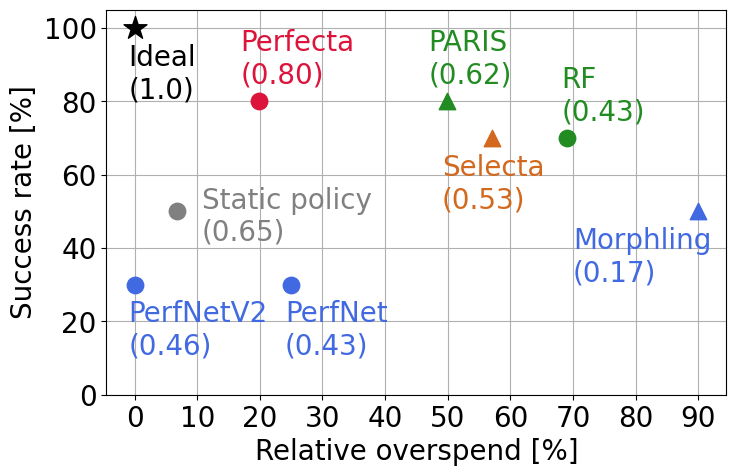

In [17]:
results = pd.read_csv('recommendation_scores.csv', index_col=0)
label_shifts = {
    'Perfecta': [-3, 5],
    'Selecta': [-8, -19],
    'PARIS': [-3, 5],
    'Morphling': [-20, -19],
    'RF': [-1, 5],
    'PerfNet': [-1, -19],
    'PerfNetV2': [-8, 5],
    'Static policy': [4, -8],
}
colors = {
    'Perfecta': 'crimson',
    'Selecta': 'chocolate',
    'PARIS': 'forestgreen',
    'Morphling': 'royalblue',
    'RF': 'forestgreen',
    'PerfNet': 'royalblue',
    'PerfNetV2': 'royalblue',
    'Static policy': 'grey',    
}

fig, ax = plt.subplots(figsize=(8,5))

# Plot recommendation scores of all methods
for algo, scores in results.iterrows():
    _ = ax.scatter(x=scores['overspend'], y=scores['success_rate'], c=colors[algo], label=algo, marker='^' if algo in TWO_SHOT_METHODS else 'o', s=140, zorder=5)
    _ = ax.annotate('%s\n(%.2f)' % (algo, scores['so_score']), (scores['overspend']+label_shifts[algo][0], scores['success_rate']+label_shifts[algo][1]), zorder=10, color=colors[algo])
    
# Add theoretical ideal result
_ = ax.scatter(x=0, y=100, c='black', label='Ideal', marker='*', s=300, zorder=5)
_ = ax.annotate('Ideal\n(1.0)', (-1, 100-19), zorder=10, color='black')

_ = plt.ylabel('Success rate [%]')
_ = plt.xlabel('Relative overspend [%]')
_ = plt.ylim((0, 105))
_ = plt.xticks(range(0, 100, 10))
_ = plt.grid(zorder=0)

# Save and display
plt.tight_layout()
plt.savefig("recommendation_scores_plot.png")
plt.show()